# Baseline analysis

New simple baselines:

- DeviatingFromMean: Takes the mean of the entire TS and computes the deviation to it for each individual point as anomaly score
- DeviatingFromMedian: Takes the median of the entire TS and computes the deviation to it for each individual point as anomaly score

In [1]:
# imports
import re
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

from IPython.display import display, Markdown, Latex

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 8)

from pathlib import Path
from timeeval import MultiDatasetManager

## Configuration

Define data and results folder:

In [2]:
# constants and configuration
root_path = Path("../..").resolve()
benchmark_data_path = root_path / "data" / "benchmark-data" / "data-processed"
gutentag_data_path = root_path / "data" / "test-cases"
correlation_data_path = root_path / "data" / "correlation-anomalies"
result_root_path = root_path / "results"
experiment_result_folder = "2022-01-18_deviating-baselines"

result_path = result_root_path / experiment_result_folder
print("\nSelecting:")
print(f"Benchmark data path: {benchmark_data_path.resolve()}")
print(f"GutenTAG data path: {gutentag_data_path.resolve()}")
print(f"Correlation data path: {correlation_data_path.resolve()}")
print(f"Result path: {result_path.resolve()}")


Selecting:
Benchmark data path: /home/sebastian/Documents/projects/akita/data/benchmark-data/data-processed
GutenTAG data path: /home/sebastian/Documents/projects/akita/data/test-cases
Correlation data path: /home/sebastian/Documents/projects/akita/data/correlation-anomalies
Result path: /home/sebastian/Documents/projects/akita/results/2022-01-18_deviating-baselines


Load results and dataset metadata and define utility functions:

In [3]:
# load results
print(f"Reading results from {result_path.resolve()}")
df = pd.read_csv(result_path / "results.csv")

# aggregate runtime
df["overall_time"] = df["execute_main_time"].fillna(0) + df["train_main_time"].fillna(0)

# add RANGE_PR_AUC if it is not part of the results
if "RANGE_PR_AUC" not in df.columns:
    df["RANGE_PR_AUC"] = np.nan

# remove all duplicates (not necessary, but sometimes, we have some)
df = df.drop_duplicates()

# load dataset details
dmgr = MultiDatasetManager([
    benchmark_data_path,
    gutentag_data_path,
    correlation_data_path
])

Reading results from /home/sebastian/Documents/projects/akita/results/2022-01-18_deviating-baselines


In [4]:
def load_scores_df(algorithm_name, dataset_id, repetition=1):
    params_id = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1]), "hyper_params_id"].item()
    path = (
        result_path /
        algorithm_name /
        params_id /
        dataset_id[0] /
        dataset_id[1] /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

In [22]:
default_use_plotly = False
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

def plot_scores(algorithm_name, dataset_id, use_plotly: bool = default_use_plotly, **kwargs):
    if not isinstance(algorithm_name, list):
        algorithms = [algorithm_name]
    else:
        algorithms = algorithm_name
    # deconstruct dataset ID
    collection_name, dataset_name = dataset_id

    # load dataset details
    df_dataset = dmgr.get_dataset_df(dataset_id)

    # check if dataset is multivariate
    dataset_dim = df.loc[(df["collection"] == collection_name) & (df["dataset"] == dataset_name), "dataset_input_dimensionality"].unique().item()
    dataset_dim = dataset_dim.lower()
    
    auroc = {}
    df_scores = pd.DataFrame(index=df_dataset.index)
    skip_algos = []
    algos = []
    for algo in algorithms:
        algos.append(algo)
        # get algorithm metric results
        try:
            auroc[algo] = df.loc[(df["algorithm"] == algo) & (df["collection"] == collection_name) & (df["dataset"] == dataset_name), "ROC_AUC"].item()
        except ValueError:
            warnings.warn(f"No ROC_AUC score found! Probably {algo} was not executed on {dataset_id}.")
            auroc[algo] = -1
            skip_algos.append(algo)
            continue

        # load scores
        training_type = df.loc[df["algorithm"] == algo, "algo_training_type"].values[0].lower().replace("_", "-")
        try:
            df_scores[algo] = load_scores_df(algo, dataset_id).iloc[:, 0]
        except (ValueError, FileNotFoundError):
            warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_id}.")
            df_scores[algo] = np.nan
            skip_algos.append(algo)
    algorithms = [a for a in algos if a not in skip_algos]

    if use_plotly:
        return plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs)
    else:
        return plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs)

def plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs):
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Create plot
    fig = make_subplots(2, 1)
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, i], name=df_dataset.columns[i][:30]), 1, 1)
    else:
        fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, 1], name="timeseries"), 1, 1)
    fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset["is_anomaly"], name="label"), 2, 1)
    
    for algo in algorithms:
        fig.add_trace(go.Scatter(x=df_scores.index, y=df_scores[algo], name=f"{algo}={auroc[algo]:.4f}"), 2, 1)
    fig.update_xaxes(matches="x")
    fig.update_layout(
        title=f"Results of {','.join(np.unique(algorithms))} on {dataset_id}",
        height=400
    )
    return py.iplot(fig)

def plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_id, **kwargs):
    import matplotlib.pyplot as plt

    # Create plot
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            axs[0].plot(df_dataset.index, df_dataset.iloc[:, i], label=df_dataset.columns[i][:30])
    else:
        axs[0].plot(df_dataset.index, df_dataset.iloc[:, 1], label=f"timeseries")
    axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")
    
    for algo in algorithms:
        axs[1].plot(df_scores.index, df_scores[algo], label=f"{algo}={auroc[algo]:.4f}")
    if len(df_dataset.columns) < 15:
        axs[0].legend()
    axs[1].legend()
    fig.suptitle(f"Results of {','.join(np.unique(algorithms))} on {dataset_id}")
    fig.tight_layout()
    plt.close()
    return fig

def plot_boxplot(df, n_show = 20, title="Box plots", ax_label="values", legend_title="Algorithms", fmt_label=lambda x: x, fliers=False, use_plotly=default_use_plotly):
    n_show = n_show // 2
    title = title + f" (worst {n_show} and best {n_show} {legend_title.lower()})"
    
    if use_plotly:
        import plotly.offline as py
        import plotly.graph_objects as go
        import plotly.figure_factory as ff
        import plotly.express as px
        from plotly.subplots import make_subplots
        
        fig = go.Figure()
        for i, c in enumerate(df.columns):
            fig.add_trace(go.Box(
                x=df[c],
                name=fmt_label(c),
                boxpoints=False,
                visible=None if i < n_show or i > len(df.columns)-n_show-1 else "legendonly"
            ))
        fig.update_layout(
            title={"text": title, "xanchor": "center", "x": 0.5},
            xaxis_title=ax_label,
            legend_title=legend_title
        )
        return py.iplot(fig)
    else:
        df_boxplot = pd.concat([df.iloc[:, :n_show], df.iloc[:, -n_show:]])
        labels = df_boxplot.columns
        labels = [fmt_label(c) for c in labels]
        values = [df_boxplot[c].dropna().values for c in df_boxplot.columns]
        fig = plt.figure()
        ax = fig.gca()
        ax.boxplot(values, sym=None if fliers else "", vert=True, meanline=True, showmeans=True, showfliers=fliers, manage_ticks=True)
        ax.set_ylabel(ax_label)
        ax.set_title(title)
        ax.set_xticklabels(labels, rotation=-45, ha="left", rotation_mode="anchor")
        # add vline to separate bad and good algos
        ymin, ymax = ax.get_ylim()
        ax.vlines([n_show + 0.5], ymin, ymax, colors="black", linestyles="dashed")
        fig.tight_layout()
        plt.close()
        return fig

def plot_algorithm_bars(df, y_name="ROC_AUC", title="Bar chart for algorithms", use_plotly=default_use_plotly):
    if use_plotly:
        fig = px.bar(df, x="algorithm", y=y_name)
        return py.iplot(fig)
    else:
        fig = plt.figure()
        ax = fig.gca()
        ax.bar(df["algorithm"], df[y_name], label=y_name)
        ax.set_ylabel(y_name)
        ax.set_title(title)
        ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
        ax.legend()
        plt.close()
        return fig

## Execution Overview

In [6]:
df[["algorithm", "collection", "dataset", "status", "ROC_AUC", "AVERAGE_PRECISION", "PR_AUC", "RANGE_PR_AUC", "execute_main_time", "hyper_params"]]

,algorithm,collection,dataset,status,ROC_AUC,AVERAGE_PRECISION,PR_AUC,RANGE_PR_AUC,execute_main_time,hyper_params
0,DeviatingFromMean,SWaT,SWaT-A1&A2,Status.OK,0.500000,0.121320,0.560660,0.560660,1.013289,{}
1,DeviatingFromMean,SWaT,SWaT-A5,Status.OK,0.500000,0.139304,0.569652,0.569652,0.055516,{}
2,DeviatingFromMean,SWaT,SWaT-A6,Status.OK,0.500000,0.068555,0.534278,0.534278,0.048667,{}
3,DeviatingFromMean,WADI,WADI.A2-1,Status.OK,0.500000,0.057737,0.528868,0.528868,1.145024,{}
4,DeviatingFromMean,WADI,WADI.A2-2,Status.OK,0.500000,0.057737,0.528868,0.528868,1.106095,{}
...,...,...,...,...,...,...,...,...,...,...
3097,DeviatingFromMedian,GutenTAG,sinus-type-trend.supervised,Status.OK,0.479022,0.009088,0.008942,0.009842,0.000648,{}
3098,DeviatingFromMedian,GutenTAG,sinus-type-trend.unsupervised,Status.OK,0.479022,0.009088,0.008942,0.009842,0.001302,{}
3099,DeviatingFromMedian,GutenTAG,sinus-type-variance.semi-supervised,Status.OK,0.508442,0.143463,0.143096,0.116722,0.000695,{}
3100,DeviatingFromMedian,GutenTAG,sinus-type-variance.supervised,Status.OK,0.508442,0.143463,0.143096,0.116722,0.000803,{}


In [7]:
df_error_counts = df.pivot_table(index="algorithm", columns=["status"], values="repetition", aggfunc="count")
df_error_counts

status,Status.OK
algorithm,
DeviatingFromMean,1546
DeviatingFromMedian,1546


## ROC_AUC scores

### Per algorithm

In [8]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_overall_scores = df.pivot_table(index="algorithm", values="ROC_AUC", aggfunc=aggregations)
df_overall_scores.columns = aggregations
df_overall_scores = df_overall_scores.sort_values(by=dominant_aggregation, ascending=False)


df_asl = df.pivot(index="algorithm", columns=["collection", "dataset"], values="ROC_AUC")
df_asl = df_asl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_asl[dominant_aggregation] = df_asl.agg(dominant_aggregation, axis=1)
df_asl = df_asl.sort_values(by=dominant_aggregation, ascending=True)
df_asl = df_asl.drop(columns=dominant_aggregation).T

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_overall_scores.T)

/home/sebastian/.conda/envs/timeeval/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



algorithm,DeviatingFromMedian,DeviatingFromMean
min,0.000051,0.000051
mean,0.605568,0.601494
median,0.561186,0.555375
max,1.000000,1.000000


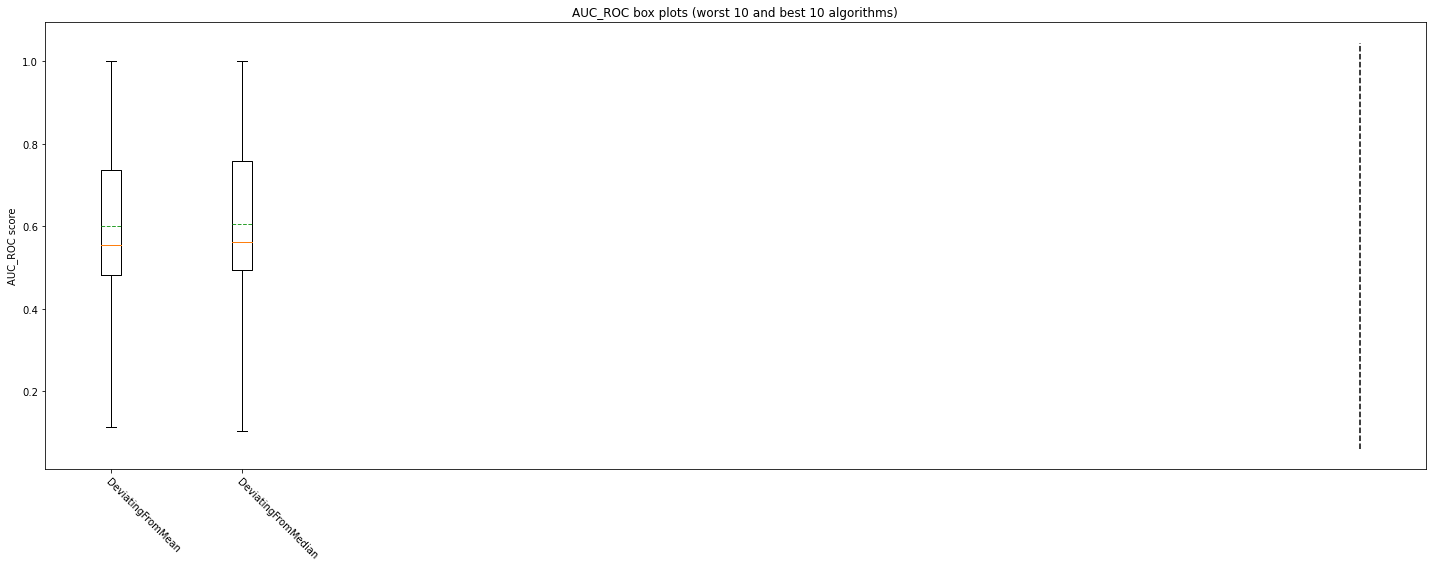

In [9]:
plot_boxplot(df_asl, title="AUC_ROC box plots", ax_label="AUC_ROC score")

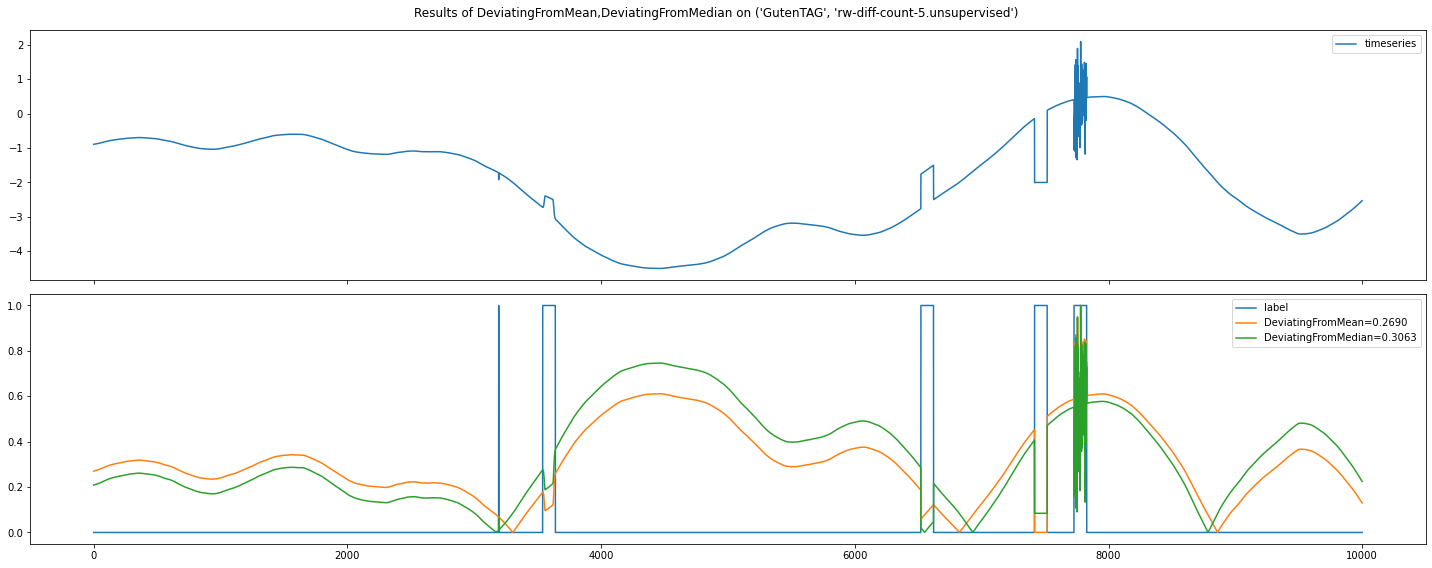

In [10]:
dataset_name = ("GutenTAG", "rw-diff-count-5.unsupervised")
algorithm_name = None
n_algos = 4

plot_scores(algorithm_name if algorithm_name else df_asl.columns[-n_algos:].to_list(), dataset_name)

### Per dataset collection

In [11]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_collection_scores = df.pivot_table(index="collection", values="ROC_AUC", aggfunc=aggregations)
df_collection_scores.columns = aggregations
df_collection_scores = df_collection_scores.sort_values(by=dominant_aggregation, ascending=False)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_collection_scores.T)

collection,Exathlon,CalIt2,IOPS,WebscopeS5,Genesis,NASA-MSL,Metro,GHL,MITDB,NASA-SMAP,SVDB,MGAB,KDD-TSAD,NAB,GutenTAG,Daphnet,Keogh,OPPORTUNITY,SMD,SWaT,WADI
min,0.998207,0.786603,0.621566,0.003521,0.691755,0.434652,0.665365,0.053317,0.381707,0.138749,0.458393,0.498978,0.024023,0.252395,0.000051,0.397008,0.293411,0.5,0.5,0.5,0.5
mean,0.998962,0.836106,0.796602,0.782318,0.725302,0.689170,0.667648,0.652068,0.623204,0.594726,0.581375,0.558623,0.547376,0.546952,0.527715,0.516615,0.511727,0.5,0.5,0.5,0.5
median,0.999029,0.836106,0.844732,0.847786,0.725302,0.671596,0.667648,0.787388,0.610672,0.580288,0.572922,0.557900,0.533789,0.531292,0.513870,0.507287,0.572321,0.5,0.5,0.5,0.5
max,0.999731,0.885610,0.871582,1.000000,0.758848,0.962332,0.669931,0.995350,0.974781,0.929298,0.726992,0.642839,0.997891,0.832167,1.000000,0.633607,0.672971,0.5,0.5,0.5,0.5


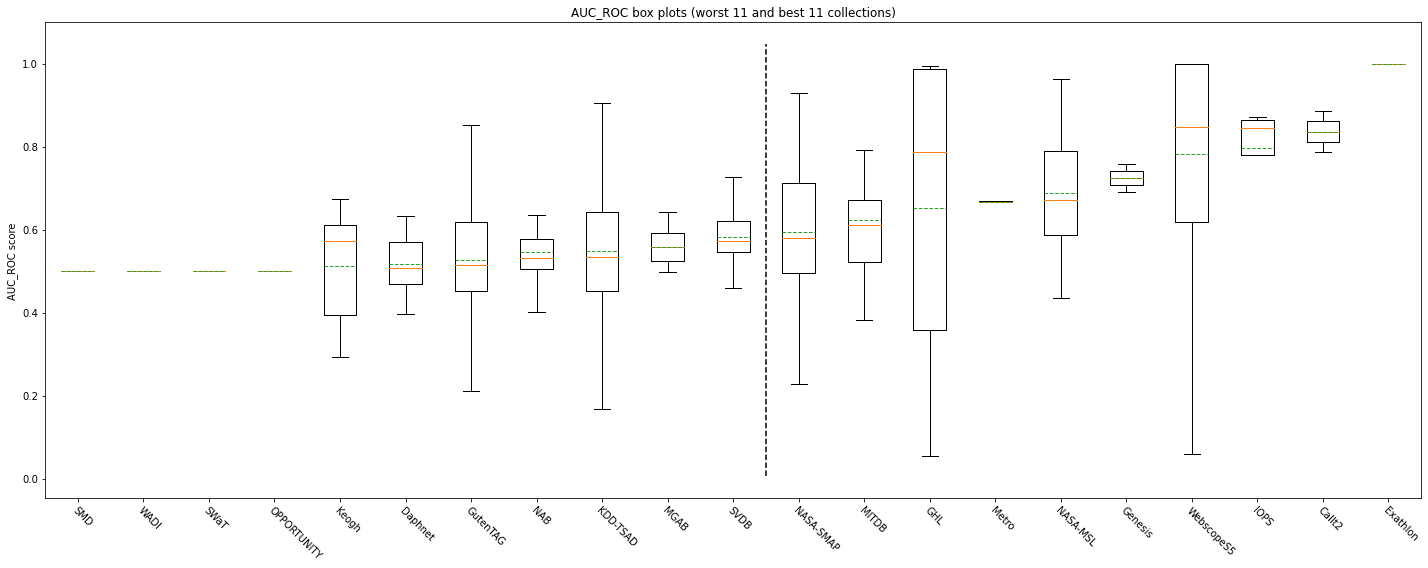

In [21]:
df_tmp = df.pivot(index="collection", columns=["algorithm", "dataset"], values="ROC_AUC")
df_tmp = df_tmp.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_tmp[dominant_aggregation] = df_tmp.agg(dominant_aggregation, axis=1)
df_tmp = df_tmp.sort_values(by=dominant_aggregation, ascending=True)
df_tmp = df_tmp.drop(columns=dominant_aggregation).T

plot_boxplot(df_tmp, title="AUC_ROC box plots", ax_label="AUC_ROC score", legend_title="Collections", n_show=22)

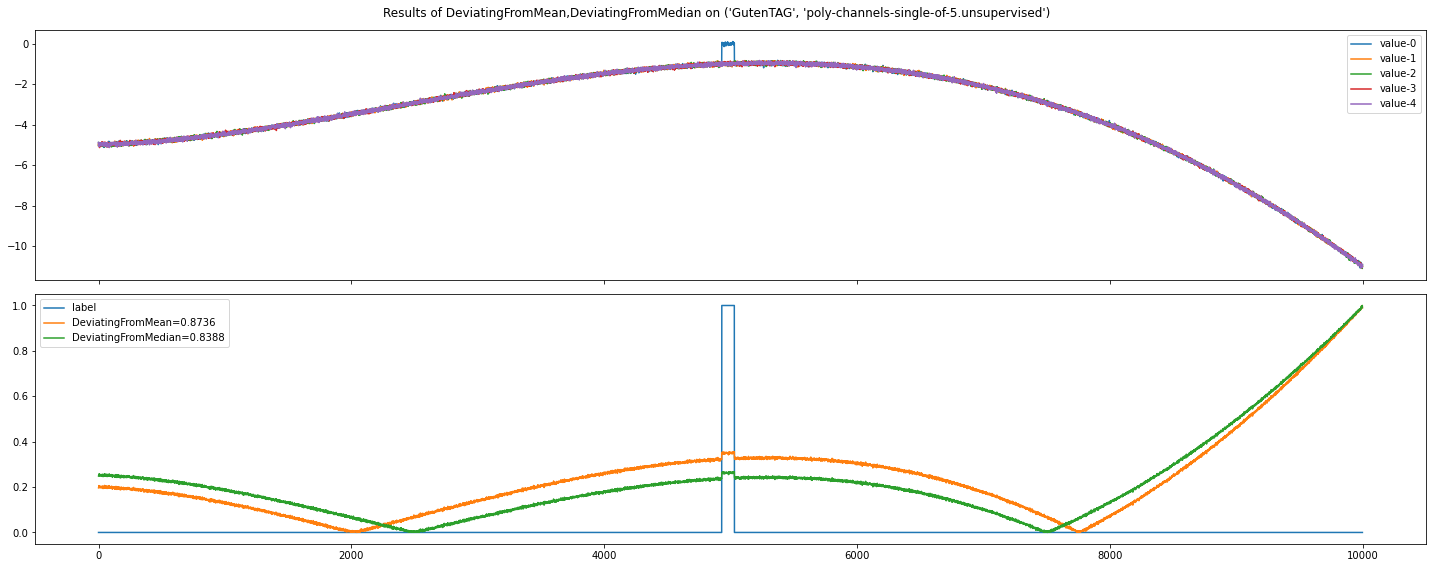

In [13]:
plot_scores(["DeviatingFromMean", "DeviatingFromMedian"], ("GutenTAG", "poly-channels-single-of-5.unsupervised"))

## Dataset assessment

Very easy datasets, because they can be solved by the baselines.

In [14]:
df_tmp = df.pivot_table(index=["collection", "dataset"], columns="algorithm", values=["ROC_AUC", "PR_AUC"])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_tmp[(df_tmp[("ROC_AUC", "DeviatingFromMean")] > 0.9) & (df_tmp[("PR_AUC", "DeviatingFromMean")] > 0.7)])

PR_AUC  \
algorithm                                      DeviatingFromMean   
collection dataset                                                 
Exathlon   4_1_100000_61-29                             0.994422   
           4_1_100000_61-30                             0.994422   
           5_1_100000_63-64                             0.994897   
           5_1_100000_64-63                             0.984559   
GutenTAG   cbf-length-1.semi-supervised                 1.000000   
           cbf-length-1.supervised                      1.000000   
           cbf-length-1.unsupervised                    1.000000   
           cbf-type-extremum.semi-supervised            1.000000   
           cbf-type-extremum.supervised                 1.000000   
           cbf-type-extremum.unsupervised               1.000000   
           ecg-length-1.semi-supervised                 1.000000   
           ecg-length-1.supervised                      1.000000   
           ecg-length-1.unsupervised                    1.000000   
           ecg-type-extremum.semi-supervised            1.000000   
           ecg-type-extremum.supervised                 1.000000   
           ecg-type-extremum.unsupervised               1.000000   
           poly-diff-count-1.semi-supervised            1.000000   
           poly-diff-count-1.supervised                 1.000000   
           poly-diff-count-1.unsupervised               1.000000   
           poly-length-1.semi-supervised                1.000000   
           poly-length-1.supervised                     1.000000   
           poly-length-1.unsupervised                   1.000000   
           poly-type-platform.semi-supervised           1.000000   
           poly-type-platform.supervised                1.000000   
           poly-type-platform.unsupervised              1.000000   
           rw-diff-count-1.semi-supervised              1.000000   
           rw-diff-count-1.supervised                   1.000000   
           rw-diff-count-1.unsupervised                 1.000000   
           rw-length-1.semi-supervised                  1.000000   
           rw-length-1.supervised                       1.000000   
           rw-length-1.unsupervised                     1.000000   
           rw-type-extremum.semi-supervised             1.000000   
           rw-type-extremum.supervised                  1.000000   
           rw-type-extremum.unsupervised                1.000000   
           sinus-length-1.semi-supervised               1.000000   
           sinus-length-1.supervised                    1.000000   
           sinus-length-1.unsupervised                  1.000000   
           sinus-type-extremum.semi-supervised          1.000000   
           sinus-type-extremum.supervised               1.000000   
           sinus-type-extremum.unsupervised             1.000000   
NASA-MSL   D-14                                         0.925776   
           M-6                                          0.889378   
NASA-SMAP  A-6                                          0.787956   
WebscopeS5 A1Benchmark-1                                1.000000   
           A1Benchmark-10                               1.000000   
           A1Benchmark-11                               0.936218   
           A1Benchmark-12                               1.000000   
           A1Benchmark-13                               0.801014   
           A1Benchmark-15                               0.940399   
           A1Benchmark-16                               1.000000   
           A1Benchmark-18                               0.763889   
           A1Benchmark-2                                0.835022   
           A1Benchmark-21                               1.000000   
           A1Benchmark-22                               0.957058   
           A1Benchmark-23                               0.838277   
           A1Benchmark-24                               1.000000   
           A1Benchmark-25                     

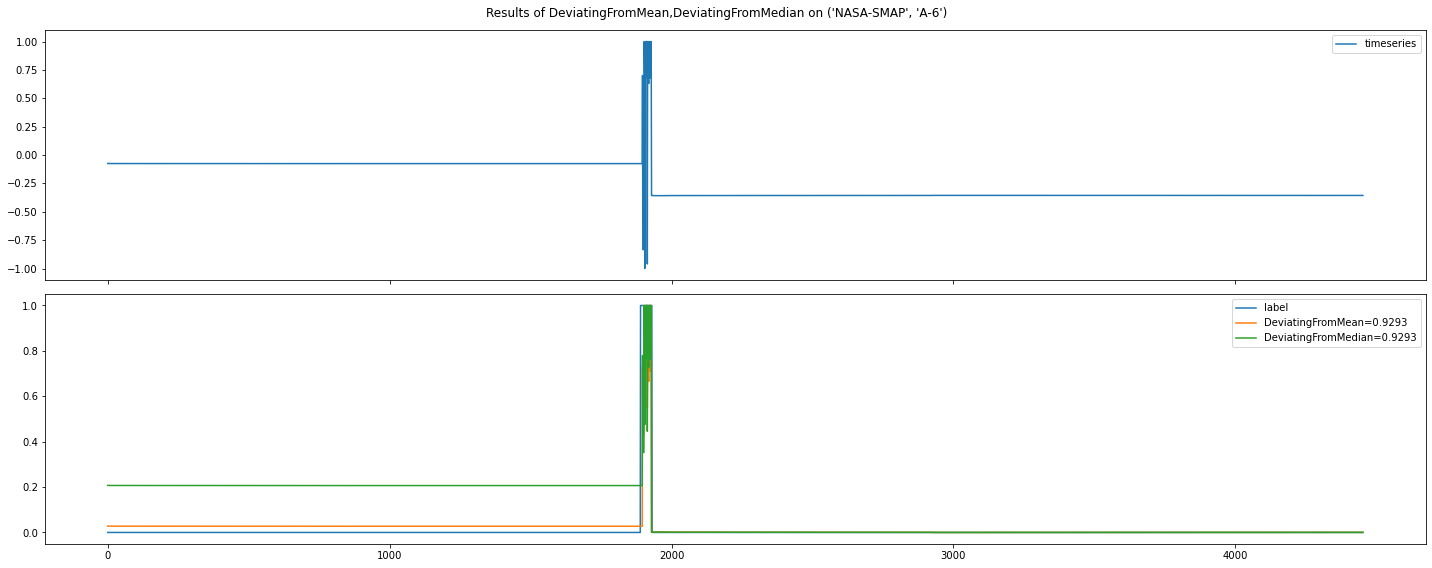

In [15]:
plot_scores(["DeviatingFromMean", "DeviatingFromMedian"], ("NASA-SMAP", "A-6"))

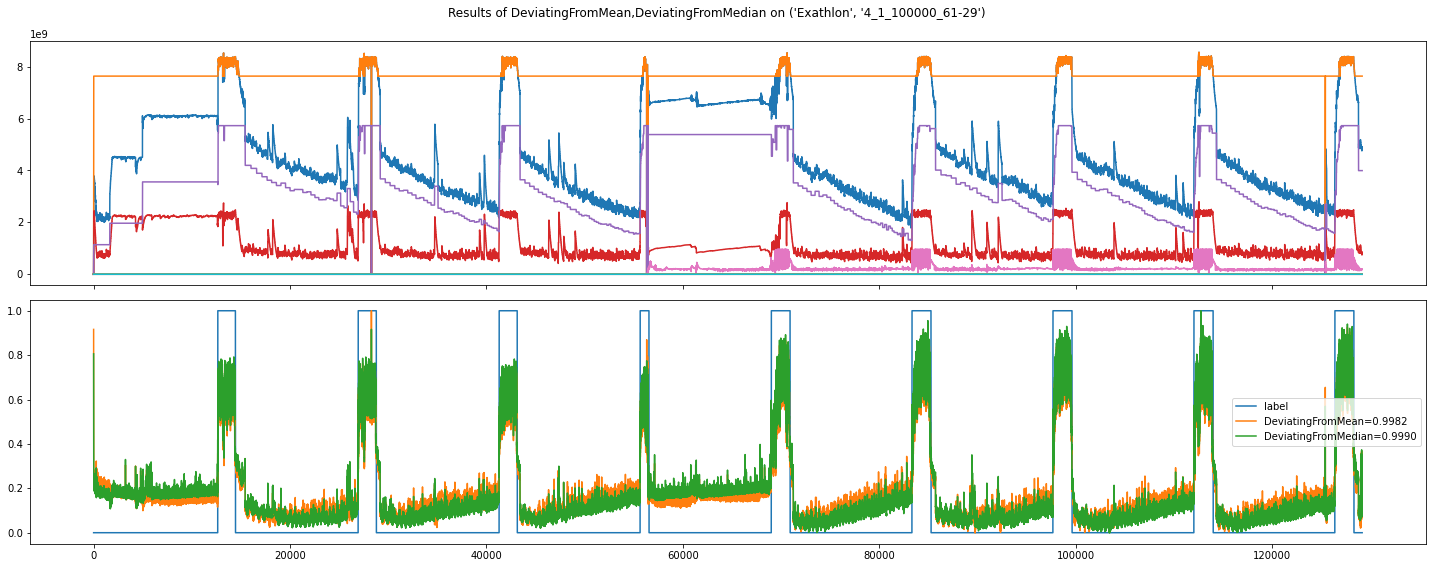

In [23]:
plot_scores(["DeviatingFromMean", "DeviatingFromMedian"], ("Exathlon", "4_1_100000_61-29"))

In [17]:
#plot_scores(["DeviatingFromMean", "DeviatingFromMedian"], ("WADI", "WADI.A2-2"))

## Compare to algorithms

In [18]:
df2 = pd.read_csv(root_path / "results" / "paper-plots-results.csv")

In [33]:
df_tmp = df2.copy()#[(df2["collection"] == "WebscopeS5") & (df2["dataset"] == "A1Benchmark-30")]
df_tmp = df_tmp.groupby(by="algorithm")[["ROC_AUC", "PR_AUC"]].mean()
df_tmp = pd.concat([df_tmp, df.groupby(by="algorithm")[["ROC_AUC", "PR_AUC"]].mean()])
df_tmp = df_tmp.sort_values("ROC_AUC", ascending=False)

display(Markdown("### Algorithms that are worse than the baselines based on ROC_AUC"))
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_tmp[df_tmp["ROC_AUC"] <= df_tmp.loc["DeviatingFromMedian", "ROC_AUC"]])

display(Markdown("### Algorithms that are worse than the baselines based on PR_AUC"))
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_tmp[df_tmp["PR_AUC"] <= df_tmp.loc["DeviatingFromMean", "PR_AUC"]].sort_values("PR_AUC", ascending=False))

### Algorithms that are worse than the baselines based on ROC_AUC

,ROC_AUC,PR_AUC
algorithm,,
DeviatingFromMedian,0.605568,0.191578
DeviatingFromMean,0.601494,0.192754
SSA,0.598004,0.357341
LaserDBN,0.595319,0.112042
HOT SAX,0.594816,0.363216
TSBitmap,0.588910,0.044869
PCC,0.588195,0.150876
DSPOT,0.551196,0.261378
FFT,0.544929,0.416914


### Algorithms that are worse than the baselines based on PR_AUC

,ROC_AUC,PR_AUC
algorithm,,
DeviatingFromMean,0.601494,0.192754
DeviatingFromMedian,0.605568,0.191578
RobustPCA,0.542928,0.190476
Torsk,0.682339,0.188936
Series2Graph,0.749552,0.181638
OceanWNN,0.677339,0.171451
PCC,0.588195,0.150876
Hybrid KNN,0.496522,0.137429
TAnoGan,0.514011,0.134715
